In [1]:
from my_commonfunctions import *

In [2]:
def draw_hough_lines(lines, shape, line_thickness):
    lines_img = np.zeros(shape)
    for l in lines:
        x1 = l[0][0]
        y1 = l[0][1]
        x2 = l[1][0]
        y2 = l[1][1]
        #print(l)
        #print(x1, y1, x2, y2)
        cv2.line(lines_img, (x1,y1), (x2,y2), (255,255,255), line_thickness)

    return lines_img

In [3]:
def potential_staff_lines(note_img_thresh, staff_thickness):
    DEG_TO_RAD = np.pi/180
    width = note_img_thresh.shape[1]

    # Hough to get potential staff lines
    line_length = int(width/4)
    lines = probabilistic_hough_line(note_img_thresh, threshold=10, line_length=line_length, line_gap=3, theta=np.arange(80*DEG_TO_RAD, 100*DEG_TO_RAD, 1*DEG_TO_RAD), seed=40)
    lines_img_before_filteration = draw_hough_lines(lines, note_img_thresh.shape, 1)
    lines_img_before_filteration = cv2.dilate(lines_img_before_filteration, np.ones((1, 11)))

    # Get widest 5 contours/lines
    lines_img = np.copy(lines_img_before_filteration)
    image, contours, hierarchy = cv2.findContours(lines_img_before_filteration.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contours_bounding_rectangles = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        #print(x, y, w, h)
        contours_bounding_rectangles.append([c, [x, y, w, h]])

    contours_bounding_rectangles_sorted = sorted(contours_bounding_rectangles, key = lambda x: x[1][2], reverse=True) # sort by width
    contours_widest_5 = []
    j = 5 if len(contours_bounding_rectangles_sorted) >= 5 else len(contours_bounding_rectangles_sorted)
    for i in range(j):
        contours_widest_5.append(contours_bounding_rectangles_sorted[i][0])

    # Draw widest 5 contours/lines
    lines_img = np.zeros(note_img_thresh.shape, dtype=np.uint8)
    lines_img = rgb2gray(cv2.drawContours(gray2rgb(lines_img), contours_widest_5, -1, (255,255,255), 1))
    k = 3
    lines_img = my_close(lines_img, np.ones((k*staff_thickness, k*staff_thickness)))
    lines_img = cv2.dilate(lines_img, np.ones((3, 3)))

    # my_show_images([lines_img])

    return lines_img

In [4]:
def remove_staff_lines(note_img_gray, staff_thickness):
    # Otsu's thresholding
    ret, note_img_thresh = cv2.threshold(note_img_gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)




    note_img_thresh = ~note_img_thresh

    # Potential staff lines
    potential_lines_img = potential_staff_lines(note_img_thresh, staff_thickness)
    lines_img_flattened = (potential_lines_img > 0.5).T.flatten()
    
    # Iterate over each column to remove any "run of white pixels" with a length of "m*staff_thickness"
    # But it must be a part from a potentail line to confirm removing (potential lines calculated above)
    note_img_thresh_flattened = (note_img_thresh).T.flatten()
    image, contours, hierarchy = cv2.findContours((note_img_thresh_flattened).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for c in contours:
        if c.shape == (2, 1, 2):
            p1 = c[1][0][1]
            p0 = c[0][0][1]
            m = 2
            if p1 - p0 <= staff_thickness*m:
                #print(c)
                staff_pixel_percentage = lines_img_flattened[p0:p1+1].sum() / len(lines_img_flattened[p0:p1+1])
                if staff_pixel_percentage > 0.35:
                    note_img_thresh_flattened[p0:p1+1] = 0
        elif c.shape == (1, 1, 2):
            #print(c)
            p0 = c[0][0][1]
            staff_pixel_percentage = lines_img_flattened[p0:p0+1].sum() / len(lines_img_flattened[p0:p0+1])
            if staff_pixel_percentage > 0.35:
                note_img_thresh_flattened[p0:p0+1] = 0


    staff_lines_removed = note_img_thresh_flattened.reshape(note_img_thresh.T.shape).T


    #my_show_images([note_img_gray, note_img_thresh, potential_lines_img, staff_lines_removed], dpi=80, row_max=5)


    return staff_lines_removed, potential_lines_img

In [5]:
def contours_mask(contours, shape):
    mask = cv2.cvtColor(np.zeros(shape[:2], dtype=np.uint8), cv2.COLOR_GRAY2BGR)
    mask = cv2.drawContours(mask, contours, -1, (255, 255, 255), -1)
    return cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

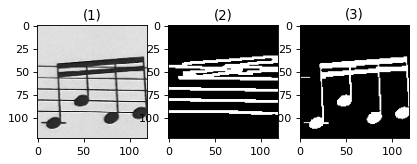

In [65]:
test = my_imread_gray('shubra1/out12.png')
# Otsu's thresholding
ret, test_img_thresh = cv2.threshold(test, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
distance_between_staves, staff_thickness = get_distance_between_staves_and_staff_thickness(test_img_thresh)


staff_lines_removed, potential_staff_l = remove_staff_lines(test, staff_thickness)
my_show_images([test, potential_staff_l, staff_lines_removed], dpi=80, row_max=3)

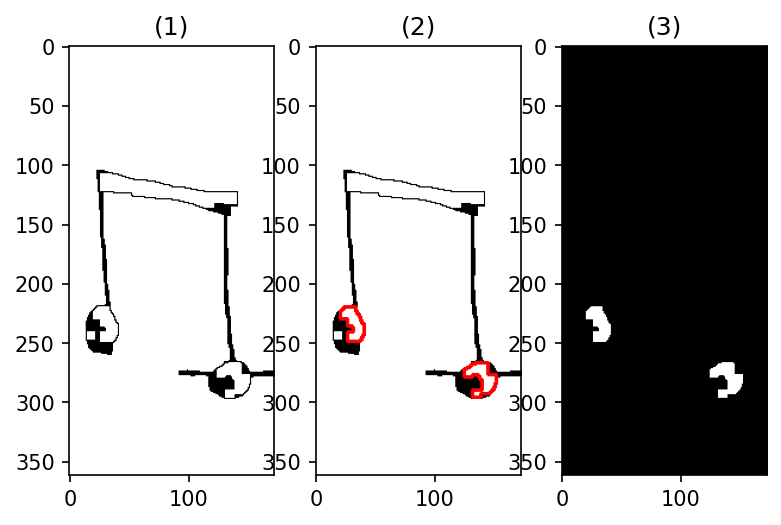

In [43]:
thresh = cv2.adaptiveThreshold(255-staff_lines_removed, 256, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 1)
thresh = my_open(thresh, np.ones((7, 7)))
image, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

my_area = thresh.shape[0]*thresh.shape[0]
contours_filtered = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    a = w*h
    if 0.003 < a/my_area < 0.025: # test 1
        if x > 0 and x+w < thresh.shape[1]: # test 2
            (xc,yc), (d1,d2), angle = cv2.fitEllipse(c)
            major_axis, minor_axis = max(d1,d2), min(d1,d2)
            if major_axis/minor_axis <= 2.2: # test 3
                epsilon = 0.02*cv2.arcLength(c, True)
                approx = cv2.approxPolyDP(c, epsilon, True)
                #print(a/my_area, major_axis/minor_axis, len(approx))
                if len(approx) > 4: # test 4
                    contours_filtered.append(c)

contours_drawn = gray2rgb(np.copy(thresh))
contours_drawn = cv2.drawContours(contours_drawn, contours_filtered, -1, (255, 0, 0), 2)
#contours_drawn = cv2.drawContours(contours_drawn, contours[2], -1, (255, 0, 0), 2)


#mask = cv2.dilate(contours_mask(contours_filtered, thresh.shape), np.ones((3, 3)))
mask = contours_mask(contours_filtered, thresh.shape)
image, contours_final, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#print(len(contours_final))


my_show_images([thresh, contours_drawn, mask], dpi=150, row_max=3)

In [8]:
?cv2.fillPoly

Docstring:
fillPoly(img, pts, color[, lineType[, shift[, offset]]]) -> img
.   @brief Fills the area bounded by one or more polygons.
.   
.   The function cv::fillPoly fills an area bounded by several polygonal contours. The function can fill
.   complex areas, for example, areas with holes, contours with self-intersections (some of their
.   parts), and so forth.
.   
.   @param img Image.
.   @param pts Array of polygons where each polygon is represented as an array of points.
.   @param color Polygon color.
.   @param lineType Type of the polygon boundaries. See #LineTypes
.   @param shift Number of fractional bits in the vertex coordinates.
.   @param offset Optional offset of all points of the contours.
Type:      builtin_function_or_method



78.53981633974483 20.0 0.5 3

78.53981633974483 1787.0 0.5 3

78.53981633974483 158.5 0.5 3
1.3458116961256756 2.2
0.6817694645609116

78.53981633974483 52.5 0.5 3
1.108690775767109 2.2
0.7510364136045856

78.53981633974483 40.0 0.5 3
1.095445119306241 2.2
0.7834930985316345

78.53981633974483 110.0 0.5 3
2.6055114936403507 2.2

78.53981633974483 34.0 0.5 3

78.53981633974483 309.0 0.5 3

78.53981633974483 258.0 0.5 3
8.96020555288499 2.2


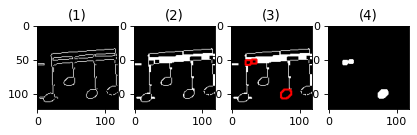

In [67]:
#thresh = cv2.adaptiveThreshold(255-staff_lines_removed_masked, 256, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 1)
_thresh = cv2.Canny(staff_lines_removed, 25, 50)
structuring_element_size = int(round(staff_thickness*5))
thresh = my_close(_thresh, np.ones((structuring_element_size, structuring_element_size)))
image, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

'''my_area = thresh.shape[0]*thresh.shape[0]
contours_filtered = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    a = w*h
    print(a/my_area)
    if 0.003 < a/my_area < 0.025: # test 1
        if x > 0 and x+w < thresh.shape[1]: # test 2
            (xc,yc), (d1,d2), angle = cv2.fitEllipse(c)
            major_axis, minor_axis = max(d1,d2), min(d1,d2)
            if major_axis/minor_axis <= 2.2: # test 3
                epsilon = 0.02*cv2.arcLength(c, True)
                approx = cv2.approxPolyDP(c, epsilon, True)
                if len(approx) > 4: # test 4
                    contours_filtered.append(c)'''

my_area = np.pi/4 * distance_between_staves**2
contours_filtered = []
for c in contours:
    print()
    x, y, w, h = cv2.boundingRect(c)
    a = cv2.contourArea(c)
    #print(a, my_area)
    print(my_area, a, 0.5, 3)
    if my_area*0.5 < a < my_area*3.5: # test 1
        if len(c)<5 :     #added edris
            continue #added edris
        (xc,yc), (d1,d2), angle = cv2.fitEllipse(c) # todo fix error : There should be at least 5 points to fit the ellipse in function 'cv::fitEllipse'
        major_axis, minor_axis = max(d1,d2), min(d1,d2)
        print(major_axis/minor_axis, 2.2)
        if major_axis/minor_axis <= 2.2: # test 2
            (xc, yc),radius = cv2.minEnclosingCircle(c)
            mec_area = np.pi * radius**2
            print(a/mec_area)
            if a/mec_area > 0.47:
                epsilon = 0.02*cv2.arcLength(c, True)
                approx = cv2.approxPolyDP(c, epsilon, True)
                if len(approx) > 4: # test 4
                    contours_filtered.append(c)
            #if x > 0 and x+w < thresh.shape[1]: # test 3
        
            

contours_drawn = gray2rgb(np.copy(thresh))
contours_drawn = cv2.drawContours(contours_drawn, contours_filtered, -1, (255, 0, 0), 2)
#contours_drawn = cv2.drawContours(contours_drawn, contours[0], -1, (255, 0, 0), 2)


#mask = cv2.dilate(contours_mask(contours_filtered, thresh.shape), np.ones((3, 3)))
mask = contours_mask(contours_filtered, thresh.shape)
image, contours_final, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#print(len(contours_final))

my_show_images([_thresh, thresh, contours_drawn, mask], dpi=80, row_max=4)